# Physical Geography

**NOTE: the river and sea setup below uses an older version of the data management structure.**

Most of those items have been moved "off camera" to the Google docs, only retaining the core physical geography object under [wfrp/physical_layers/inputs]


In [12]:
%load_ext autoreload
%autoreload 2

from world_simulator import run_river_skeleton_pipeline, test_noise, generate_fractal_noise
from world_simulator import GPUThermalEroder, CoastalTaper

from world_simulator import HydrologyAnalyzer, validate_arrow_directions, plot_flow, CalculateFlowMagnitude, plot_river_hierarchy, assign_river_widths, plot_river_physics, save_hydro_network, validate_topology_continuity




import os
import geopandas as gpd
import numpy as np
import rasterio
from gdgtm import change_raster_res


vector_src_dir = "/home/pete/Documents/wfrp/source_vectors/"
raster_src_dir = "/home/pete/Documents/wfrp/source_rasters/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## River and sea setup

Here we take a georeferenced, trimmed corase altitude map, we load it, increase resolution, and then we smooth it.

We use an erosion approach to overal smoothing and aim for Int16 data type - which gives us some serious mileage in the "disk saving department" - 100s of MBs.

The exact maths are indicated in the class docstring for the GPUThermalEroder. For now it is relevant to note that we went for a short erosion (100 steps), slow erosion rate (0.05), and a high threshold of 2. What this means is that we preserve most of the high ground on the map, while introducing just a little smoothing around the slopes to remove the blockiness. Not perfect, but the step below will take care of doing perfect :)



### Vectorizing the river net from QGIS polys

The goal here is to take a bunch of QGIS polygons and change them into an actual net of lines for downstream processing.

In [ ]:
# if __name__ == "__main__":
#     # Example configuration
#     IN_FILE = os.path.join(vector_src_dir, "wfrp_empire_rivers_poly.gpkg")
#     OUT_FILE = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
    
#     # Config
#     GAP_TOLERANCE = 3500     # 20km gap filling
#     INTERP_DISTANCE = 250     # 500m vertex resolution
#     PRUNE = 3500
    
#     if os.path.exists(IN_FILE):
#         run_river_skeleton_pipeline(IN_FILE, OUT_FILE, GAP_TOLERANCE, INTERP_DISTANCE, PRUNE)
#     else:
#         print(f"File not found: {IN_FILE}")

In [ ]:
# ### Phase 1: Make the rivers flow and make them have the right size.

# if __name__ == "__main__":

#     # rivers_path = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
#     sea_path = os.path.join(vector_src_dir, "wfrp_empire_sea_poly.gpkg")
#     lakes_path = os.path.join(vector_src_dir, "wfrp_empire_lakes_poly.gpkg")
#     rivers_path = os.path.join(vector_src_dir, "wfrp_empire_rivers_line.gpkg")
    
#     rivers = gpd.read_file(rivers_path) # The output from skeletonization
#     sea = gpd.read_file(sea_path)       # You need this
#     lakes = gpd.read_file(lakes_path)   # You need this (Canonical lakes)

#     ### Step 1: Orient the rivers in the correct direction.
#     analyzer = HydrologyAnalyzer(rivers, sea, lakes)
#     oriented_rivers = analyzer.run()
#     validate_arrow_directions(oriented_rivers, analyzer.G)
#     # plot_flow(oriented_rivers, sea, lakes)

#     ### Step 2: Establish river hierarchy
#     # 1. Get the Directed Graph from the Phase 1 Analyzer
#     flow_calculator = CalculateFlowMagnitude(analyzer.DiG)
#     # 2. Calculate Magnitude
#     dag_with_flow = flow_calculator.run()
#     # 3. Visualize
#     # plot_river_hierarchy(dag_with_flow, sea, lakes)

In [ ]:
# if __name__ == "__main__":
#     OUT_FILE = os.path.join(vector_src_dir, "wfrp_empire_major_rivers_net.gpkg")
#     ### Step 3: Work out river widths:
#     rivers_with_width = assign_river_widths(
#         dag_with_flow, 
#         min_width=20.0,    # Source streams are 20m wide
#         max_width=1000.0,   # The Reik is 800m wide at Altdorf - we make it 1000 for our 250m grid.
#         scale_factor=100.0  # Multiplier for the log growth
#     )
    
#     # 2. Restore CRS (Important for buffering!)
#     rivers_with_width.set_crs(rivers.crs, inplace=True)
    
#     # 3. Visualize
#     # plot_river_physics(rivers_with_width, sea, lakes)
#     save_hydro_network(rivers_with_width, OUT_FILE)

In [4]:
# validate_topology_continuity(rivers_with_width)

--- TOPOLOGY CONTINUITY CHECK ---
Checked 100 junctions.
SUCCESS: Water flows continuously from line to line.


### Sea set-up

Here we prep the sea



In [1]:
# =============================================================================
#  IMPORTS
# =============================================================================

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import geopandas as gpd
import rasterio

# from world_simulator.terrain_engine import CoordinateEngine
# Added necessary utility functions for Step 2
from world_simulator.misc_utils import (
    vector_to_mask, 
    generate_fractal_mask, 
    measure_fractal_dimension,
    repair_mask_artifacts
)


/home/pete/miniconda/envs/gdgtm_dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074409.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074410.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074410.log
INFO: Logging initialized. Writing to: logs/wfrp_phys_geo_20251224_074410.log


In [2]:
# =============================================================================
#  STEP 1: LOAD CONTEXT DATA
# =============================================================================

vector_src = "/home/pete/Documents/wfrp/source_vectors"
raster_src = "/home/pete/Documents/wfrp/source_rasters"

# A. The Base DEM (Canvas & Starting Heights)
base_dem_path = os.path.join(raster_src, "wfrp_empire_smoothed_topo.tif") # From your previous step
with rasterio.open(base_dem_path) as src:
    base_profile = src.profile
    base_shape = (src.height, src.width)
    base_elevation = src.read(1) # Start with existing terrain

# B. Vectors
rivers_gdf = gpd.read_file(os.path.join(vector_src, "wfrp_empire_major_rivers_net.gpkg"))
lakes_gdf = gpd.read_file(
    os.path.join(vector_src, "wfrp_empire_lakes_poly.gpkg"),
    layer="wfrp_empire_lakes")
sea_gdf = gpd.read_file(os.path.join(vector_src, "wfrp_empire_sea_poly.gpkg")) # Explicit Sea Load



In [3]:
# =============================================================================
#  STEP 2: PRE-PROCESS COAST (Measure & Mimic)
# =============================================================================
# --- A. COASTAL ANALYSIS ---
print("Analyzing Coastline Physics...")

# 1. Rasterize (Get the shape)
raw_sea_mask = vector_to_mask(sea_gdf, base_profile)

# Define the artifact zones (Map edges/NoData boundaries)
# Format: (West_Col, North_Row, East_Col, South_Row)
artifact_boxes = [
    (0, 1050, 100, 1300),   # Box 1: West edge artifact
    (3500, 0, 7100, 900)    # Box 2: Northern edge artifact
]

# 2. Measure the "Native" Fractal Dimension
# We measure the complexity at coarse scales (e.g., 2km to 64km).
# This tells us if the coast is "Scottish" (High D) or "Floridian" (Low D).
# We stop at min_scale=16px (~2km) to avoid reading the square pixel artifacts.
measured_d = measure_fractal_dimension(
    mask=raw_sea_mask,
    min_scale=16,   # Ignore details smaller than ~2km
    max_scale=512,  # Measure up to ~64km bays
    exclusion_boxes=artifact_boxes  # <--- Plugged in here
)

# print(f"Measured Fractal Dimension: {measured_d}")

# Safety Clamp: Real coastlines rarely exceed 1.5 or drop below 1.1
measured_d = np.clip(measured_d, 1.1, 1.45)
print(f"  > Detected Fractal Dimension: {measured_d:.3f}")

# 3. Synthesize Detail
# We use the measured D to generate the sub-pixel details.
fractal_sea_mask = generate_fractal_mask(
    mask=raw_sea_mask,
    fractal_dimension=measured_d,  # <--- The Measurement informs the Synthesis
    scale=20.0,
    seed=123
)

# 4. Repair Boundaries
# We surgically restore the straight edges in the artifact boxes
# to prevent the fractal noise from 'chewing' up the map border.
print("Repairing map boundary artifacts...")
fractal_sea_mask = repair_mask_artifacts(
    fractal_mask=fractal_sea_mask,
    reference_mask=raw_sea_mask,      # The clean original
    boxes=artifact_boxes,             # <--- Plugged in here again
    base_dem=base_elevation,          # Check for valid data
    nodata_value=base_profile.get('nodata', -32768)
)

Analyzing Coastline Physics...
INFO: Rasterizing 11 vector features into mask...
  > Detected Fractal Dimension: 1.224
Repairing map boundary artifacts...
INFO: Repairing artifacts in 2 zones...


In [4]:
# =============================================================================
#  DEBUG EXPORT: FRACTAL SEA MASK
# =============================================================================
output_mask_path = os.path.join(raster_src, "wfrp_coast_mask_test.tif")
print(f"Exporting debug mask to {output_mask_path}...")

# Prepare Profile
mask_profile = base_profile.copy()
mask_profile.update({
    'dtype': 'uint8',
    'count': 1,
    'compress': 'lzw',
    'nodata': 0 
})

with rasterio.open(output_mask_path, 'w', **mask_profile) as dst:
    # Cast Boolean (True/False) to Uint8 (1/0)
    # OPTIONAL: Multiply by 255 so it appears as Black/White in QGIS immediately
    # without needing to stretch the histogram manually.
    debug_data = fractal_sea_mask.astype('uint8') * 255
    
    dst.write(debug_data, 1)

print("Debug export complete.")

Exporting debug mask to /home/pete/Documents/wfrp/source_rasters/wfrp_coast_mask_test.tif...
Debug export complete.


## Topography: 

The plan is outlined here: https://github.com/pete-jacobsson/enemy_rebuilt/wiki/Topography

In [1]:
# ==============================================================================
# 0. IMPORTS & SETUP
# ==============================================================================
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path
import numpy as np

# The Package (To be developed)
import pyworldsim.core as core
import pyworldsim.generation as gen
# import pyworldsim.io as io

# Visualization
import matplotlib.pyplot as plt




In [2]:
# ==============================================================================
# 1. GLOBAL CONFIGURATION
# ==============================================================================
# This is the "Tuning Board". All magic numbers go here.

CONFIG = {
    "paths": {
        "inputs": "/home/pete/Documents/wfrp/physical_layers/inputs",
        "outputs": "/home/pete/Documents/wfrp/physical_layers/outputs",
        "checkpoints": "/home/pete/Documents/wfrp/physical_layers/checkpoints",
        "template_tif": "/home/pete/Documents/wfrp/physical_layers/inputs/physical_template.tif",
        "vectors": {
            "bounds": "simulation_bounds.gpkg",
            "sea": "sea_polygon.gpkg",
            "rivers": "canonical_rivers.gpkg",
            "lakes": "canonical_lakes.gpkg",
            "orogeny": "orogeny_axes.gpkg"
        }
    },
    "resolution": {
        "sim_pixel_size": 500.0,  # 500m simulation grid
        "final_pixel_size": 100.0 # 100m target output
    },
    "lithology_codes": {
        "sedimentary": 10,
        "igneous": 20,
        "fault_zone": 30,
        "sugar_sea": 99
    },
    "epochs": {
        "init": {
            "base_level": -50.0,
            
            "orogeny_spines": {
                "description": "Parameters for the OrogenySpineGenerator (The Invisible Walls)",
                "spine_roughness": 0.4,       # 0.0 = Smooth Vectors, 1.0 = Jagged Lightning
                "spur_interval_px": 20.0,     # Distance between orthogonal 'Ribs' (10km)
                "spur_length_max_px": 50.0,   # Max length of mountain ribs (25km)
                "raster_buffer_px": 3.0       # Width of the 'Wall' in the Ghost Terrain mask
            },

            "river_network": {
                "description": "Parameters for the Antecedent/Ghost River Generator",
                
                # 1. Rainfall (The Attractor)
                # Controls the Perlin noise clouds that decide where rivers start
                "attractor_noise_scale": 150.0, 
                "attractor_octaves": 4,
                "seed": 42,
                
                # 2. Flow Physics (The Droplets)
                "droplet_count": 5000,        # How many tributary starts to spawn
                "max_path_length": 3000,      # Max length in pixels (1500km) to prevent loops
                "min_path_length": 10,        # Cull tiny puddles (<5km)
                
                # 3. Lithology Burning (The Scars)
                # Defines the width of the 'Soft Zones' passed to the Eroder
                "burn_widths": {
                    "1": 1,  # Minor streams (500m)
                    "2": 2,
                    "3": 3,
                    "4": 4,
                    "5": 6   # The Reik (3km wide fault zone)
                }
            }
        },
        "orogeny": {
            "thermal_iters_oe3": 50,  # Melt the roots
            "thermal_iters_oe2": 30,  # Round the shield
            "thermal_iters_oe1": 10,  # Sharpen the peaks
            "talus_angle": 35.0,
            "subsidence_strength": 0.8
        },
        "glaciation": {
            "ice_lat_limit": 1200,    # Y-coordinate or Latitude
            "scour_depth": 150.0,
            "kettle_density": 0.02
        },
        "breach": {
            "breach_coords": (1850, 1400), # Approx coords
            "inertia": 0.85,               # High inertia = wide curves
            "erosion_width": 3.0           # 3 pixels (1.5km)
        },
        "recent": {
            "rebound_amp": 80.0,
            "loess_density": 1.0           # Multiplier for sediment budget
        }
    }
}

# Ensure directories exist
os.makedirs(CONFIG["paths"]["checkpoints"], exist_ok=True)
os.makedirs(CONFIG["paths"]["outputs"], exist_ok=True)

# Helper for Checkpointing
def load_or_run(checkpoint_name, run_func, context):
    """Checks for checkpoint. If exists, loads it. Else, runs function."""
    cp_path = Path(CONFIG["paths"]["checkpoints"]) / f"{checkpoint_name}.npz"
    
    if cp_path.exists():
        print(f"✅ Loading Checkpoint: {checkpoint_name}")
        context.load_state(cp_path)
    else:
        print(f"🚀 Running Simulation: {checkpoint_name}")
        run_func(context)
        print(f"💾 Saving Checkpoint: {checkpoint_name}")
        context.save_state(cp_path)

In [9]:
# ==============================================================================
# 2. INITIALIZATION (Epoch 0)
# ==============================================================================

# Initialize the central state object
world = core.WorldState(CONFIG)

def run_initialization(ctx):
    print("--- STARTING EPOCH 0: INITIALIZATION ---")
    
    # 1. Load Vector Inputs
    #    Loads sea, bounds, and 'oe' axes
    ctx.load_vectors()
    
    # 2. Create Masks (Active Zone, Void)
    gen.ActiveSimulationMask(ctx).apply()
    
    # 3. Create Base Seabed (-50m + Noise)
    gen.PrimordialSeabed(level=CONFIG["epochs"]["init"]["base_level"]).apply(ctx)
    
    # 4. Generate Orogeny Skeleton (The Invisible Walls)
    #    Creates 'skeleton_mask' but does NOT burn it to lithology yet (as per instruction).
    spine_gen = gen.OrogenySpineGenerator(ctx)
    spine_gen.generate_structural_vectors() 
    spine_gen.rasterize_structure()          
    
    # 5. Generate Antecedent Rivers (The Ghost Terrain)
    river_gen = gen.RiverNetworkGenerator(ctx)
    river_gen.generate_attractor_field() 
    river_gen.grow_fractal_network()
    river_gen.burn_fractures() 
    
    # 6. Apply Lithology (The Material Handoff)
    litho_mgr = gen.LithologyManager(ctx)
    
    #    A. Set global base (Sedimentary)
    litho_mgr.apply_base_lithology(default_id=CONFIG["lithology_codes"]["sedimentary"])
    
    #    B. Burn Special Zones (Sea and Rivers)
    #    We use the existing class method which looks for 'fracture_mask' in ctx.layers
    #    and 'sea' in ctx.vectors automatically.
    litho_mgr.burn_special_zones(
        sea_id=CONFIG["lithology_codes"]["sugar_sea"],
        fault_id=CONFIG["lithology_codes"]["fault_zone"]
    )

# Execute
load_or_run("01_initialization", run_initialization, world)

WorldState initialized. Grid shape: (1111, 1797). CRS: PROJCS["WFRP_Big_World_Lambert",GEOGCS["WFRP_Big_Datum",DATUM["WFRP_Big_Datum",SPHEROID["International_1924_Scaled_x1.414",9020404.57,297],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",30],PARAMETER["central_meridian",10],PARAMETER["standard_parallel_1",43],PARAMETER["standard_parallel_2",62],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
🚀 Running Simulation: 01_initialization
--- STARTING EPOCH 0: INITIALIZATION ---
Loading vector inputs...
  - Loaded bounds: 1 features.
  - Loaded sea: 493 features.
  - Loaded rivers: 112264 features.
  - Loaded lakes: 80 features.
  - Loaded orogeny: 10 features.
Generating Active Simulation Mask...
  > Healing mask artifacts...
    - Filled 2 void pixels.
  > Active 

Generating visual checks...


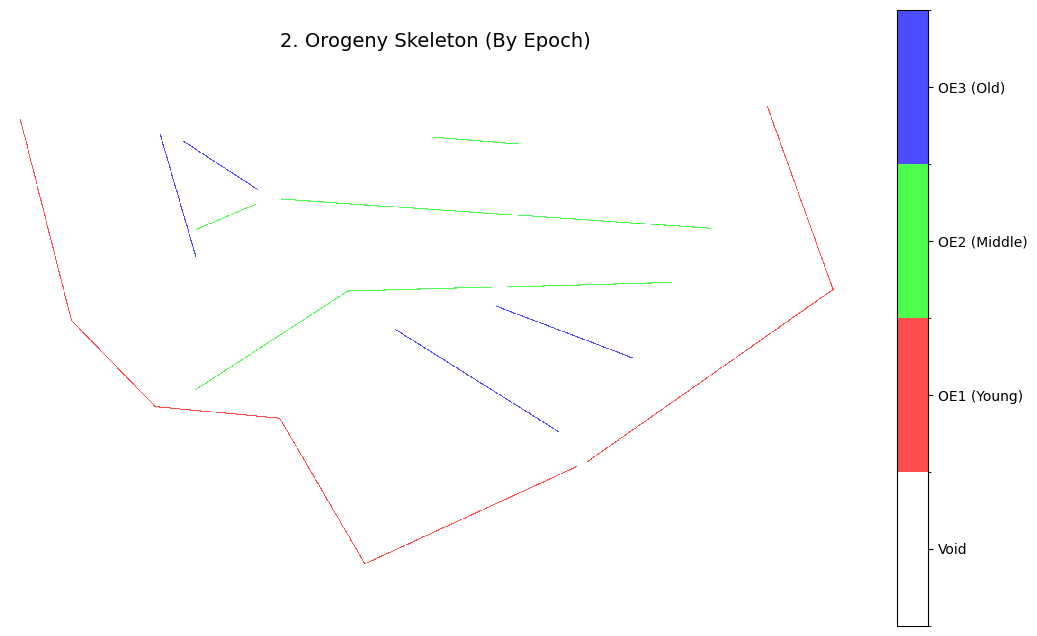

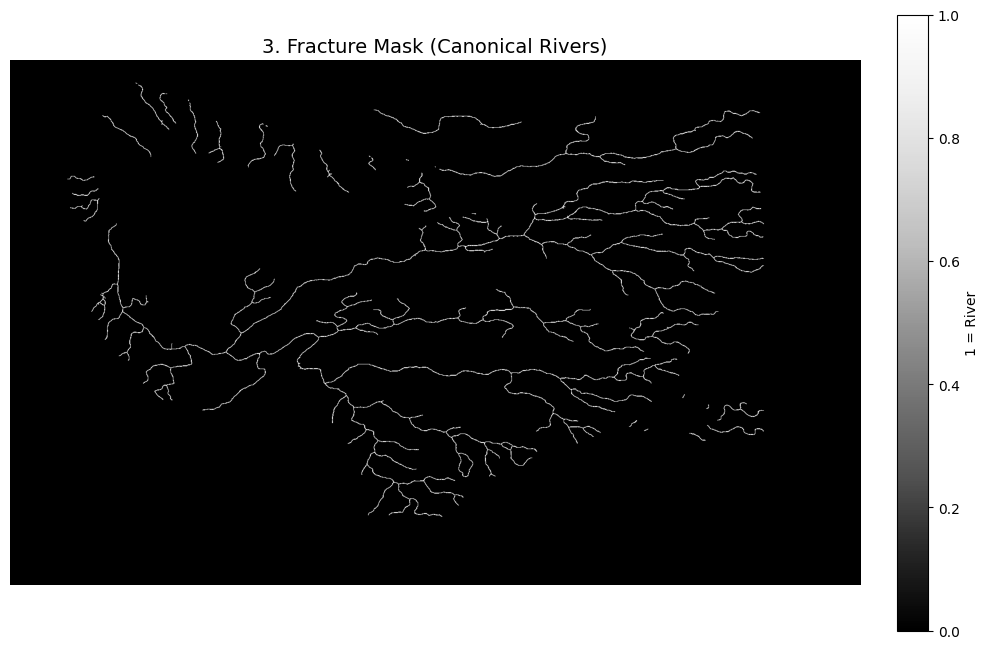

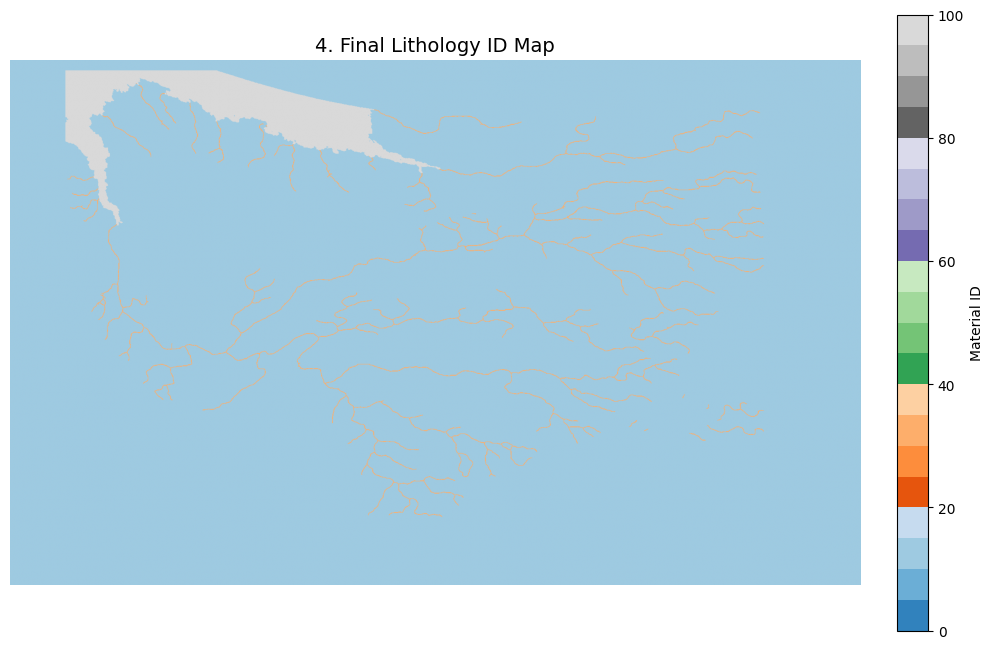

In [11]:
# ==============================================================================
# VISUAL VERIFICATION EPOCH 1 (Updated)
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

print("Generating visual checks...")

def plot_discrete_layer(data, title, label_map):
    """
    Custom plotter for discrete integer maps (Epochs).
    """
    plt.figure(figsize=(12, 8))
    
    if data is None or np.max(data) == 0:
        plt.text(0.5, 0.5, f"{title}\nDATA MISSING OR EMPTY", ha='center', fontsize=20, color='red')
        plt.title(title, fontsize=14)
        plt.axis('off')
        plt.show()
        return

    # Create a custom colormap: 0=White, 1=Red, 2=Green, 3=Blue
    # (Adjust colors as you like)
    colors = ['white', '#ff4d4d', '#4dff4d', '#4d4dff'] 
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    im = plt.imshow(data, cmap=cmap, norm=norm, interpolation='nearest')
    
    # Custom Legend
    cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5], fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(['Void', 'OE1 (Young)', 'OE2 (Middle)', 'OE3 (Old)'])
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

def plot_layer(data, title, cmap, vmin=None, vmax=None, label=None):
    plt.figure(figsize=(12, 8))
    if data is None:
        plt.text(0.5, 0.5, f"{title}\nDATA MISSING", ha='center', fontsize=20, color='red')
    else:
        plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(label=label, fraction=0.046, pad=0.04)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

# 1. Rainfall (Pass)
rain = world.layers.get("attractor_field")
# plot_layer(rain, "1. Rainfall Attractor", 'Blues', label="Rainfall Probability") # Optional

# 2. Orogeny Skeleton (The Critical Check)
# We expect to see lines in 3 distinct colors
skeleton = world.layers.get("skeleton_mask")
plot_discrete_layer(
    skeleton, 
    "2. Orogeny Skeleton (By Epoch)", 
    {1: "OE1", 2: "OE2", 3: "OE3"}
)

# 3. Fracture Mask
fractures = world.layers.get("fracture_mask")
plot_layer(fractures, "3. Fracture Mask (Canonical Rivers)", 'Greys_r', label="1 = River")

# 4. Final Lithology
litho = world.lithology_id
plot_layer(litho, "4. Final Lithology ID Map", 'tab20c', vmin=0, vmax=100, label="Material ID")

In [ ]:
# ==============================================================================
# 3. OROGENY (Epoch 2: 400MA - 200MA)
# ==============================================================================

def run_orogeny(ctx):
    cfg = CONFIG["epochs"]["orogeny"]
    
    # --- OE3 (Ancient Roots) ---
    print("  > Processing OE3...")
    gen.VectorOrogeny(ctx, epoch_id=3).apply()
    gen.ThermalEroder(ctx).run(iterations=cfg["thermal_iters_oe3"])
    
    # --- OE2 (The Collision) ---
    print("  > Processing OE2...")
    gen.VectorOrogeny(ctx, epoch_id=2).apply()
    gen.TectonicSubsidence(ctx).apply_talabec_graben()
    gen.ThermalEroder(ctx).run(iterations=cfg["thermal_iters_oe2"])
    
    # --- OE1 (The Great Walls) ---
    print("  > Processing OE1...")
    gen.VectorOrogeny(ctx, epoch_id=1).apply() # Also applies Metamorphic Halo
    
    # --- Canonical Lake Basins ---
    gen.TectonicSubsidence(ctx).enforce_canonical_lakes()
    
    # --- Final Pre-Ice Polish ---
    gen.ThermalEroder(ctx).run(iterations=cfg["thermal_iters_oe1"])

load_or_run("02_orogeny", run_orogeny, world)

In [ ]:
# ==============================================================================
# 4. GLACIATION (Epoch 3: 2.5MA)
# ==============================================================================

def run_glaciation(ctx):
    cfg = CONFIG["epochs"]["glaciation"]
    
    # 1. Scour the North (Harvest Sediment)
    gen.GlacialScour(ctx).run(
        limit_lat=cfg["ice_lat_limit"],
        depth=cfg["scour_depth"]
    )
    # Note: ctx.sediment_budget is now populated
    
    # 2. Create Kettle Holes (Sour Moors)
    gen.EmergentLakeManager(ctx).generate_kettles(density=cfg["kettle_density"])

load_or_run("03_glaciation", run_glaciation, world)

In [ ]:
# ==============================================================================
# 5. CATASTROPHE (Epoch 4: 0.05MA)
# ==============================================================================

def run_catastrophe(ctx):
    cfg = CONFIG["epochs"]["breach"]
    
    # 1. The Altdorf Breach (Inertia Walkers)
    # This carves the gorge and dumps the delta
    gen.HydraulicBreachEvent(ctx).run(
        start_coords=cfg["breach_coords"],
        inertia=cfg["inertia"],
        width=cfg["erosion_width"]
    )

load_or_run("04_catastrophe", run_catastrophe, world)

In [ ]:
# ==============================================================================
# 6. RECENT HISTORY (Epoch 5: Holocene)
# ==============================================================================

def run_recent(ctx):
    cfg = CONFIG["epochs"]["recent"]
    
    # 1. Isostatic Rebound (Tilt the North)
    gen.IsostaticRebound(ctx).apply(amplitude=cfg["rebound_amp"])
    
    # 2. Aeolian Transport (Distribute the Sediment Budget)
    gen.AeolianTransport(ctx).distribute_loess(density_mod=cfg["loess_density"])
    
    # 3. Emergent Oxbows (River Cleanup)
    gen.EmergentLakeManager(ctx).generate_oxbows()

load_or_run("05_recent", run_recent, world)

In [ ]:
# ==============================================================================
# 7. POST-PROCESSING (Upscale & Texture)
# ==============================================================================

def run_post_process(ctx):
    # 1. Bicubic Upscale (500m -> 100m)
    # This returns a NEW high-res object or updates internal state
    ctx.upscale_to_target() 
    
    # 2. Apply Phase 4 Noise (Texture)
    gen.SurfaceNoiseDetailer(ctx).apply()
    
    # 3. Classify Soils (Porosity/Nutrients)
    gen.SurfaceGeologyClassifier(ctx).classify()
    
    # 4. Export
    io.GeoExporter(ctx).export_all(CONFIG["paths"]["outputs"])

# Usually we don't checkpoint the huge 100m file, just save the result
run_post_process(world)

print("Done.")